<a href="https://colab.research.google.com/github/tarankalra1/ipython-notebooks/blob/master/GEE_LSTM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PART 1- Multivariate LSTM deep learning model to predict streamflow**
<br><br>
$My Background:$  

I am data scientist working with NOAA to develop a hydrologic modeling tool named t-route, a dynamic channel routing model that is part of the National Water Model (NWM). This model provides a comprehensive solution for river network routing challenges. More detail can be found in [github](https://github.com/AminTorabi-NOAA/t-route/tree/master).
<br><br>
$Introduction:$

This article will be 2 parts, in first part we will go through accessing observed USGS data for a specific point (Brays Bayou, TX) and obtaining meteorological data for hydrologic modeling using Google Earth Engine (GEE). In this Part, we will train and tune hyper parameter of a Long-Short-Term Memory (LSTM) model to simulate streamflow. In Part 2, we will train transformers and ultimately compare the results with t-route (link above).
  
Here's the roadmap for our journey:
1. **Initialization and Data Retrieval:**
  - Initializes the Earth Engine,
  - fetches USGS water data,
  - and processes the response to create a usable DataFrame.
2. **Mapping and Visualization:**
  - Creates a folium map to visualize the location and surrounding basin.
3. **Fetching ERA5 Data:**
  - Retrieves ERA5 meteorological data and processes it into a DataFrame.
4. **Data Preparation:**
  - Prepares the combined dataset for LSTM model input using a custom function.
5. **Building and Training the LSTM Model:**
  - Defines, builds, trains and tune the LSTM model using TensorFlow and Keras.
6. **Evaluation and Visualization:**
  - Evaluates the model’s performance and visualizes the results using matplotlib.

This study is inspired by [this](https://nbviewer.org/github/biplovbhandari/tensorflow-ml-models/blob/master/Hydrological_Modeling_using_GEE_and_LSTM.ipynb?flush_cache=True) notebook, However the hyper parameter here is tuned and another model will be added in future and compare with t-route
  <br><br>
  # LETS START!




In [ ]:
# !pip install tensorflow[complete]
!pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


## Import all the necessary libraries

In [ ]:
import pandas as pd
import requests
from io import StringIO
import ee
import tensorflow as tf
from keras import models, optimizers, layers, callbacks, backend as K
from sklearn import preprocessing
from datetime import datetime
import folium
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# Initialize Earth Engine

Make sure to open account with google earth engine first and select a project_id name.

**Brief explanation on GEE**
<br>
Google Earth Engine (GEE) is a cloud-based platform for planetary-scale environmental data analysis. Here's a quick rundown of what it offers:

  **1- Data Access:** GEE provides access to a vast repository of geospatial datasets, including satellite imagery, climate data, and environmental data. This includes data from sources like Landsat, Sentinel, MODIS, and many more.

  **2- Cloud Computing:** It leverages Google's cloud infrastructure to process and analyze large datasets efficiently. This means you can run complex analyses on terabytes of data without needing powerful local hardware.

  **3- APIs and Code Editor:** GEE has APIs for both JavaScript and Python, allowing you to write and run code for data analysis. The web-based Code Editor provides a convenient interface to write, debug, and visualize your code and results.

  **4- Applications:** It's used in various fields such as climate change research, deforestation monitoring, agricultural forecasting, water resource management, and urban planning.

  **5- Visualization:** GEE allows you to create visualizations and maps that can be easily shared or embedded in web applications.

In [ ]:
# Project ID for Earth Engine, replace with yours
project_id = 'gee-lstm'

try:
    ee.Initialize(project=project_id)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=project_id)

# Define the study period- 30 years


In [ ]:
START_DATE = "1990-07-01"
END_DATE = "2020-07-01"

# Calculate the number of days between START_DATE and END_DATE
start_date = datetime.strptime(START_DATE, "%Y-%m-%d")
end_date = datetime.strptime(END_DATE, "%Y-%m-%d")
difference = end_date - start_date
print(difference)
print(difference.days + 1)  # includes END_DATE

10958 days, 0:00:00
10959


## location of the usgs gages
Below is the location of the usgs gages obtained from QGIS, that we will train our model on

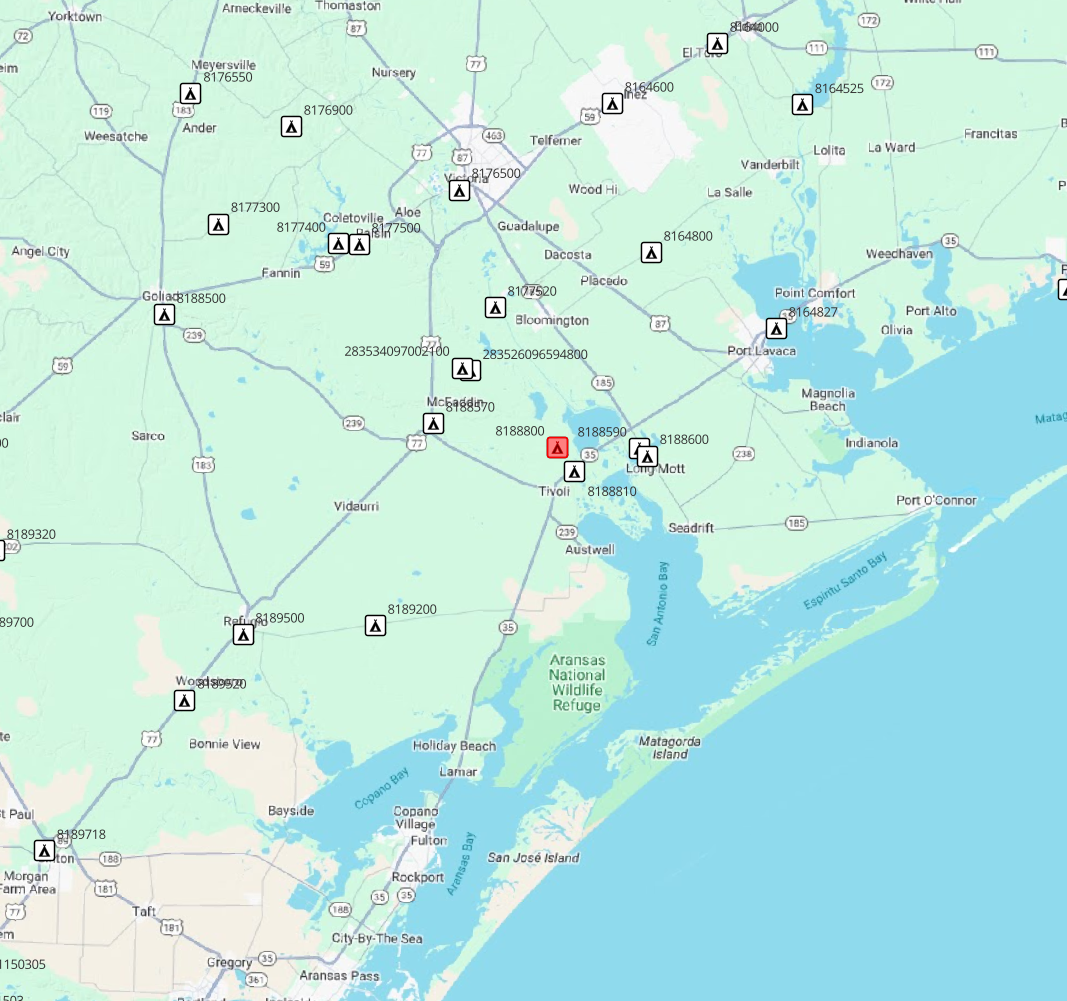

# Fetch usgs data- flowrate
I select USGS site number for Guadelope River, TX  
tried and train on couple more stations. feel free to train yours. You can download and look all the detail information about gages from [usgs website](https://waterdata.usgs.gov/nwis/uv)

In [ ]:
# siteNumber = '08075000'  # I tried couple site number, feel free to try yours
# siteNumber = "02387500"

siteNumber = '08188800' # guadelope river- Replace with your site number
usgs_water_data_url = "https://waterdata.usgs.gov/nwis/dv"
params = {
    "site_no": siteNumber,
    "begin_date": START_DATE,
    "end_date": END_DATE,
    "format": "rdb",
    "parameter_cd": "00060",  # Discharge, cubic feet per second (Mean)
}

response = requests.get(usgs_water_data_url, params=params)

if response.status_code == 200:
    print("Successful!")
else:
    print(response.status_code)
    print(response.reason)


Successful!


# Parse the response data

In [ ]:

header, table = response.text.split("# \n")
col_names = ["agency", "site", "datetime", "discharge", "quality"]
df = pd.read_csv(StringIO(table), sep="\t")
df = df.iloc[1:, :5]
df.columns = col_names

df

,agency,site,datetime,discharge,quality
1,USGS,08188800,2000-08-04,645,A
2,USGS,08188800,2000-08-05,571,A
3,USGS,08188800,2000-08-06,761,A
4,USGS,08188800,2000-08-07,697,A
5,USGS,08188800,2000-08-08,978,A
...,...,...,...,...,...
7268,USGS,08188800,2020-06-27,996,A:>
7269,USGS,08188800,2020-06-28,1370,A:>
7270,USGS,08188800,2020-06-29,1400,A:>
7271,USGS,08188800,2020-06-30,1250,A:>


# Process the dataframe

In [ ]:
df = df[["datetime", "discharge"]].copy()
df["discharge"] = df["discharge"].astype(float) * 0.0283168  # Convert to m^3/s
df.index = pd.to_datetime(df["datetime"])
df.drop("datetime", axis=1, inplace=True)

# Define gauge location for Point Of Interest (POI)

In [ ]:
# gauge_lat, gauge_lon = 29.69717469, -95.41216200
# gauge_lat, gauge_lon = 34.5775, -84.941917

gauge_lat, gauge_lon = 28.50583370,	-96.88470840   # guadelope

gauge_geom = ee.Geometry.Point([gauge_lon, gauge_lat])

# Fetch basin data using goggle earth engine

In [ ]:
hydrosheds = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_8")
basin = hydrosheds.filterBounds(gauge_geom)
basinOutline = ee.Image().byte().paint(featureCollection=basin, color=1, width=3).getMapId()

# Create map

In [ ]:

map = folium.Map(location=[gauge_lat, gauge_lon], zoom_start=11)

# Add the custom tile layer
folium.TileLayer(
    tiles=basinOutline["tile_fetcher"].url_format,
    attr="Google Earth Engine",
    overlay=True,
    name="River Basin",
).add_to(map)

# Add a marker
folium.Marker([gauge_lat, gauge_lon]).add_to(map)

# Add a layer control
map.add_child(folium.LayerControl())

# Display the map
map


# Specify band names of interest for ERA5 data

In [ ]:
meta_data = [
    "total_precipitation",
    "minimum_2m_air_temperature",
    "maximum_2m_air_temperature",
    "u_component_of_wind_10m",
    "v_component_of_wind_10m",
    "surface_pressure"
]

# Fetch ERA5 data for the specified bands and region.

In [ ]:
def fetch_era5_data(start_date, end_date, bands, region, scale):
    """
    Args:
        start_date (str): Start date for data collection.
        end_date (str): End date for data collection.
        bands (list): List of band names to fetch.
        region (ee.Geometry): Region of interest.
        scale (int): Scale in meters for data request.

    Returns:
        DataFrame: Pandas DataFrame containing the fetched data.
    """
    try:
        era5 = ee.ImageCollection("ECMWF/ERA5/DAILY")\
            .filterDate(start_date, ee.Date(end_date).advance(1, "day"))\
            .select(bands)
        lumped_forcings = era5.getRegion(region, scale).getInfo()
        forcing_df = pd.DataFrame(lumped_forcings[1:])
        forcing_df.columns = lumped_forcings[0]
        return forcing_df
    except Exception as e:
        print(f"Error fetching ERA5 data: {e}")
        return None

# Fetch ERA5 data
the `scale` parameter represents the spatial resolution of the data request in meters. Essentially, it specifies the size of each pixel in the output image or dataset.  
In summary, the `scale` parameter controls the spatial resolution of the ERA5 meteorological data that you are fetching for your region of interest.

In [ ]:

scale = 30000  # Request scale in meters
forcing_df = fetch_era5_data(START_DATE, END_DATE, meta_data, basin, scale)

if forcing_df is not None:
    print(f"Forcing DataFrame shape: {forcing_df.shape}")
else:
    print("Failed to retrieve ERA5 data")

# Ensure 'id' and 'time' columns exist
if 'id' not in forcing_df.columns or 'time' not in forcing_df.columns:
    raise KeyError("The columns 'id' and 'time' must be present in the DataFrame.")

# Group by 'id' and aggregate data
forcing_df = forcing_df.groupby(by="id").agg({
    "time": "mean",
    "minimum_2m_air_temperature": "mean",
    "maximum_2m_air_temperature": "mean",
    "u_component_of_wind_10m": "mean",
    "v_component_of_wind_10m": "mean",
    "surface_pressure": "mean",
    "total_precipitation": "mean",
})

Forcing DataFrame shape: (10959, 10)


In [ ]:
forcing_df

,time,minimum_2m_air_temperature,maximum_2m_air_temperature,u_component_of_wind_10m,v_component_of_wind_10m,surface_pressure,total_precipitation
id,,,,,,,
19900701,6.467904e+11,296.552765,306.865540,-2.184765,1.563790,101622.125000,0.000643
19900702,6.468768e+11,298.108429,307.230377,-1.214229,2.373688,101401.523438,0.000151
19900703,6.469632e+11,296.596985,307.627808,-0.405195,2.984116,101151.648438,0.000002
19900704,6.470496e+11,296.758423,307.668396,-1.043205,3.227914,101189.718750,0.000013
19900705,6.471360e+11,298.319427,305.516357,-1.455792,3.120468,101345.023438,0.002725
...,...,...,...,...,...,...,...
20200627,1.593216e+12,299.886078,303.509216,-2.028149,4.005996,101347.601562,0.001560
20200628,1.593302e+12,300.806152,303.216888,-1.730962,5.370479,100963.898438,0.000666
20200629,1.593389e+12,300.847595,304.141388,-1.589647,6.840145,100859.000000,0.000447


# Convert 'time' to datetime and set as index

In [ ]:

forcing_df.index = pd.to_datetime(forcing_df["time"] * 1e6, unit='ns')
forcing_df.index.name = "datetime"
forcing_df.drop(["time"], axis=1, inplace=True)

# Rename columns for better readability

In [ ]:
new_cols = ["tmin", "tmax", "uwind", "vwind", "psurface", "precip"]
forcing_df.columns = new_cols

# Combine USGS and ERA5 data

In [ ]:

model_df = pd.concat([df, forcing_df], axis=1)
model_df.dropna(inplace=True)
model_df.head()

,discharge,tmin,tmax,uwind,vwind,psurface,precip
datetime,,,,,,,
2000-08-04,18.264336,298.510620,305.201874,-1.276065,3.341801,101447.023438,0.001563
2000-08-05,16.168893,297.500732,306.533905,-1.197798,3.312558,101511.914062,0.000740
2000-08-06,21.549085,298.722107,307.054749,-1.357669,4.286754,101266.101562,0.000643
2000-08-07,19.736810,298.498169,306.810211,-2.448555,3.137742,101286.250000,0.000848
2000-08-08,27.693830,298.705963,304.992249,-2.740540,2.555180,101328.101562,0.004681


**Loss and Metrics:** The build_model function  uses 'huber_loss' for the loss and includes 'mae', 'mse', and 'mape' as metrics. below is the explanation of those.  
**Evaluation:** The evaluation step captures the Huber loss, MAE, MSE, and MAPE.
<br><br>
* **mean absolute percentage error (MAPE):** is the percentage equivalent of mean absolute error (MAE). $$ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$

* **Root Mean Squared Error (RMSE):**   $$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

* **Mean Absolute Error (MAE):** $$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i | $$

**Huber loss** is a loss function used in robust regression that is less sensitive to outliers than the squared error loss. It combines the best properties of both the Mean Squared Error (MSE) and Mean Absolute Error (MAE). The Huber loss is quadratic for small errors and linear for large errors. This makes it more robust to outliers in data compared to the MSE.

The formula for the Huber loss is defined as follows:
$$
L_\delta(a) =
\begin{cases}
\frac{1}{2}a^2 & \text{for } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{for } |a| > \delta
\end{cases}
$$
Where:   
* $a = y_i - \hat{y}_i$
is the difference between the actual value and the predicted value.  
* $ \delta $ is a threshold parameter that determines the point where the loss function changes from quadratic to linear.
* The Huber loss is particularly useful when you have data with outliers, as it minimizes the impact of these outliers on the model.

<Axes: xlabel='datetime'>

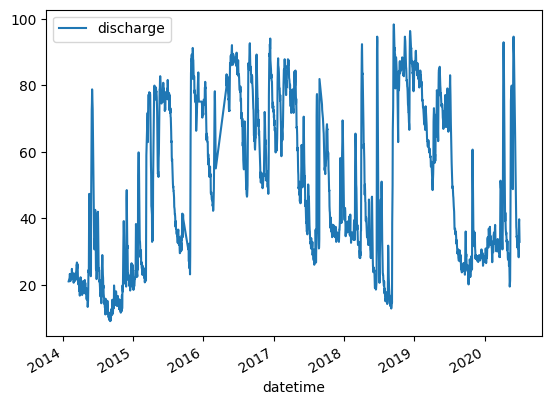

In [ ]:
model_df[-2192:].plot(y = 'discharge', use_index=True)

In [ ]:
# Split data into training and testing sets
test_split = round(len(model_df) * 0.20)

df_for_training = model_df[:-test_split]

df_for_testing = model_df[-test_split:]

print(df_for_training.shape)
print(df_for_testing.shape)

# Scale the data
scaler = RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

(5426, 7)
(1357, 7)


In [ ]:
# Create sequences
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = createXY(df_for_training_scaled, 30)
testX, testY = createXY(df_for_testing_scaled, 30)

In [ ]:
# Build the model
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(30, trainX.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae', 'mse', 'mape'])
    return model

# Wrapping the build_model function
grid_model = KerasRegressor(build_model, verbose=1)

# Define the grid search parameters
parameters = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

# Fit the model and capture the training history
history = grid_search.fit(trainX, trainY, validation_data=(testX, testY))

# Print the best parameters and score
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_.model_
loss, mae, mse, mape = best_model.evaluate(testX, testY)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test MAPE: {mape}")

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 0.0382 - mae: 0.2006 - mape: 108906.6250 - mse: 0.0765 - val_loss: 0.0143 - val_mae: 0.1216 - val_mape: 467134.9062 - val_mse: 0.0286
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0140 - mae: 0.1189 - mape: 187784.6250 - mse: 0.0281 - val_loss: 0.0115 - val_mae: 0.1043 - val_mape: 459766.3125 - val_mse: 0.0230
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0106 - mae: 0.1032 - mape: 383846.1250 - mse: 0.0211 - val_loss: 0.0097 - val_mae: 0.0928 - val_mape: 543414.5000 - val_mse: 0.0194
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0093 - mae: 0.0951 - mape: 65530.0547 - mse: 0.0186 - val_loss: 0.0103 - val_mae: 0.1013 - val_mape: 842254.0000 - val_mse: 0.0205
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0079 - mae: 0.0893 - mape: 115678.7891 - mse: 0.0157 - val_loss: 0.0083 - val_mae: 0.0877 - val_mape: 701973.9375 - val_mse: 0.0165
Epoch 6/10
169/169 ━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


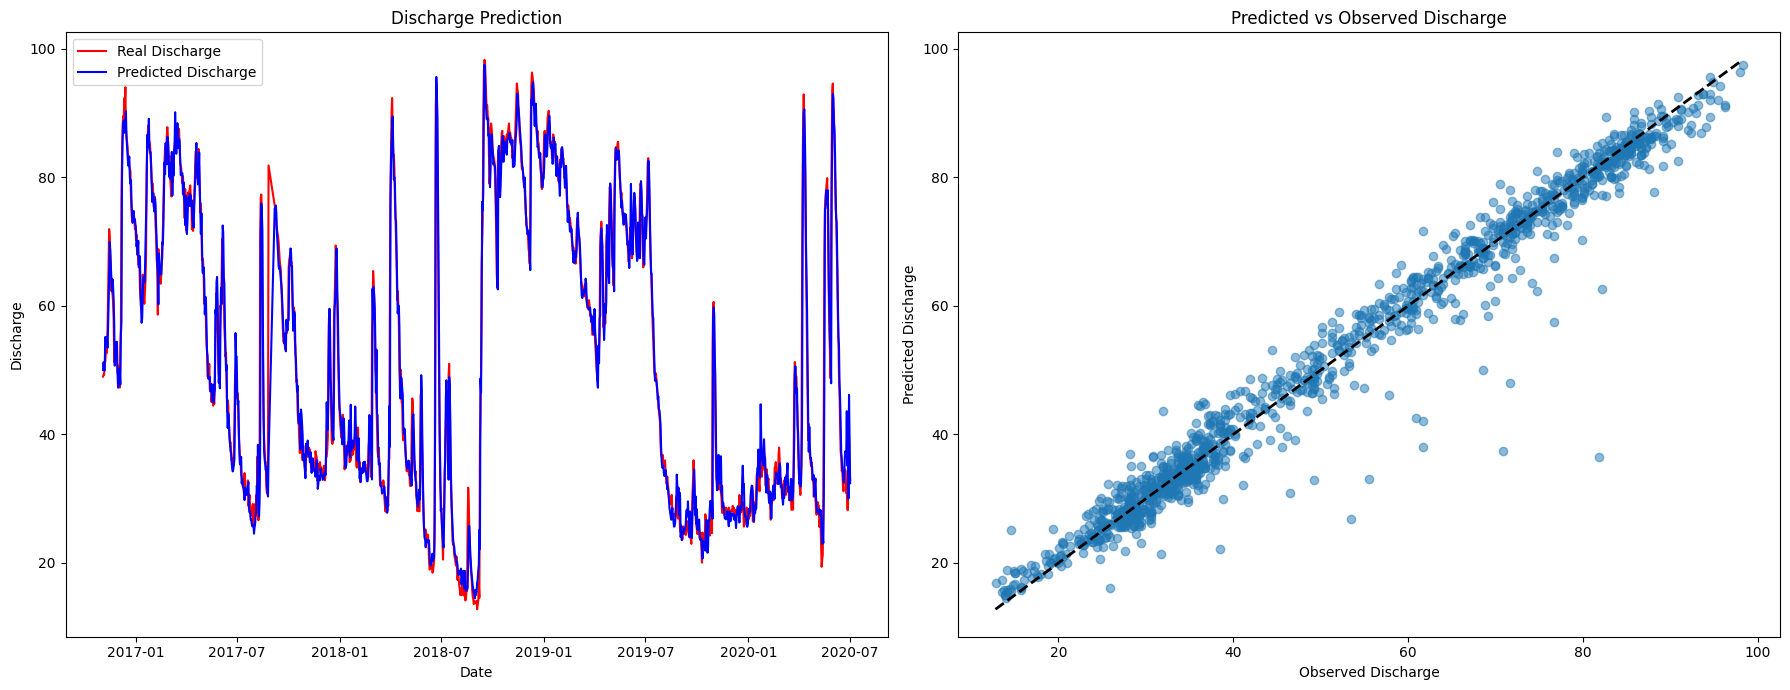

In [ ]:
# Make predictions
prediction = best_model.predict(testX)

# Prepare arrays for inverse scaling
n_features = trainX.shape[2]
prediction_copies_array = np.repeat(prediction, n_features, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), n_features)))[:,0]

original_copies_array = np.repeat(testY, n_features, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), n_features)))[:,0]

# Extract the dates for the test set
test_dates = df_for_testing.index[-len(testY):]

# Plot time series and predicted vs observed data as subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Time series plot
axes[0].plot(test_dates, original, color='red', label='Real Discharge')
axes[0].plot(test_dates, pred, color='blue', label='Predicted Discharge')
axes[0].set_title('Discharge Prediction')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Discharge')
axes[0].legend()

# Predicted vs observed data plot
axes[1].scatter(original, pred, alpha=0.5)
axes[1].plot([original.min(), original.max()], [original.min(), original.max()], 'k--', lw=2)
axes[1].set_xlabel('Observed Discharge')
axes[1].set_ylabel('Predicted Discharge')
axes[1].set_title('Predicted vs Observed Discharge')

plt.tight_layout()
plt.show()

# Capture the training history from the best estimator
best_history = grid_search.best_estimator_.history_




## As we can see it can predict very well with MAE: 0.045

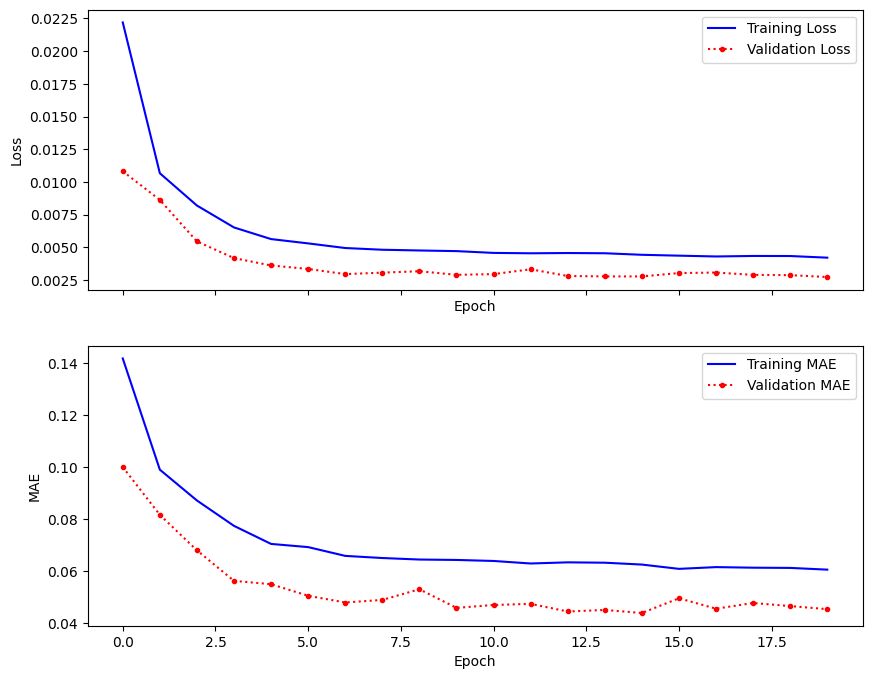

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
# Plot training & validation loss values

ax[0].plot(best_history['loss'], label='Training Loss', color='blue')
ax[0].plot(history.best_estimator_.history_['val_loss'], label='Validation Loss', color='red', linestyle=":", marker="o", markersize=3)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Plot training & validation MAE values
ax[1].plot(best_history['mean_absolute_error'], label='Training MAE', color='blue')
ax[1].plot(history.best_estimator_.history_['val_mae'], label='Validation MAE', color='red', linestyle=":", marker="o", markersize=3)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
plt.show()


In [ ]:
best_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 30, 50)              │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,555 (373.27 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,704 (248.85 KB)